In [49]:
from fit_completeness_to_catalog import *
import os
name = "barclay"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected 352 stars
Making synth solar systems


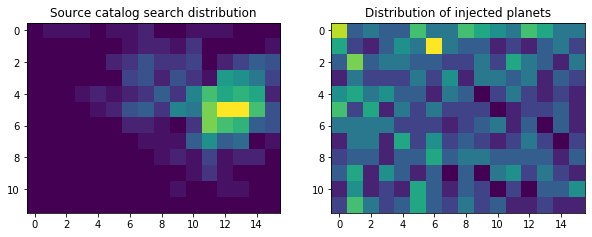

Injected 575 transiting planets


In [50]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 10000
# use the number of stars that were considered as TESS targets
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

In [52]:
max_iters = 1000000
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)

_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [ 5.09611239e-02 -1.56641249e-02  4.10890340e-05 -5.69702731e-03
  3.09022341e-01  2.50524443e-01  1.13462698e+00 -1.55351367e-01]
Set initial condition


In [54]:
i = 0
while True:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        sampler.run_mcmc(p0, 1000, store=True)
        print(i)
        i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
emcee: Exception while calling your likelihood function:
  params: [-2.07876268e-03 -4.16791172e-03 -6.20589981e-04  1.49122308e-01
  1.02154392e+00 -2.28655113e-01  1.30038508e+00  4.01564574e-01]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "<ipython-input-54-d28c7bf780a4>", line 4, in <module>
    print(sampler.get_autocorr_time())
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 526, in get_autocorr_time
    return self.backend.get_autocorr_time(**kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/backends/backend.py", line 150, in get_autocorr_time
    return thin * autocorr.integrated_time(x, **kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py", line 110, in integrated_time
    raise AutocorrError(tau_est, msg)
emcee.autocorr.AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2700;
tau: [ 9268.65539904   608.07605357   591.17843926  8343.36311412
 10011.4904847  10703.68277956 12521.3661876  11257.35397131]

During handling of the above exceptio

KeyboardInterrupt: 

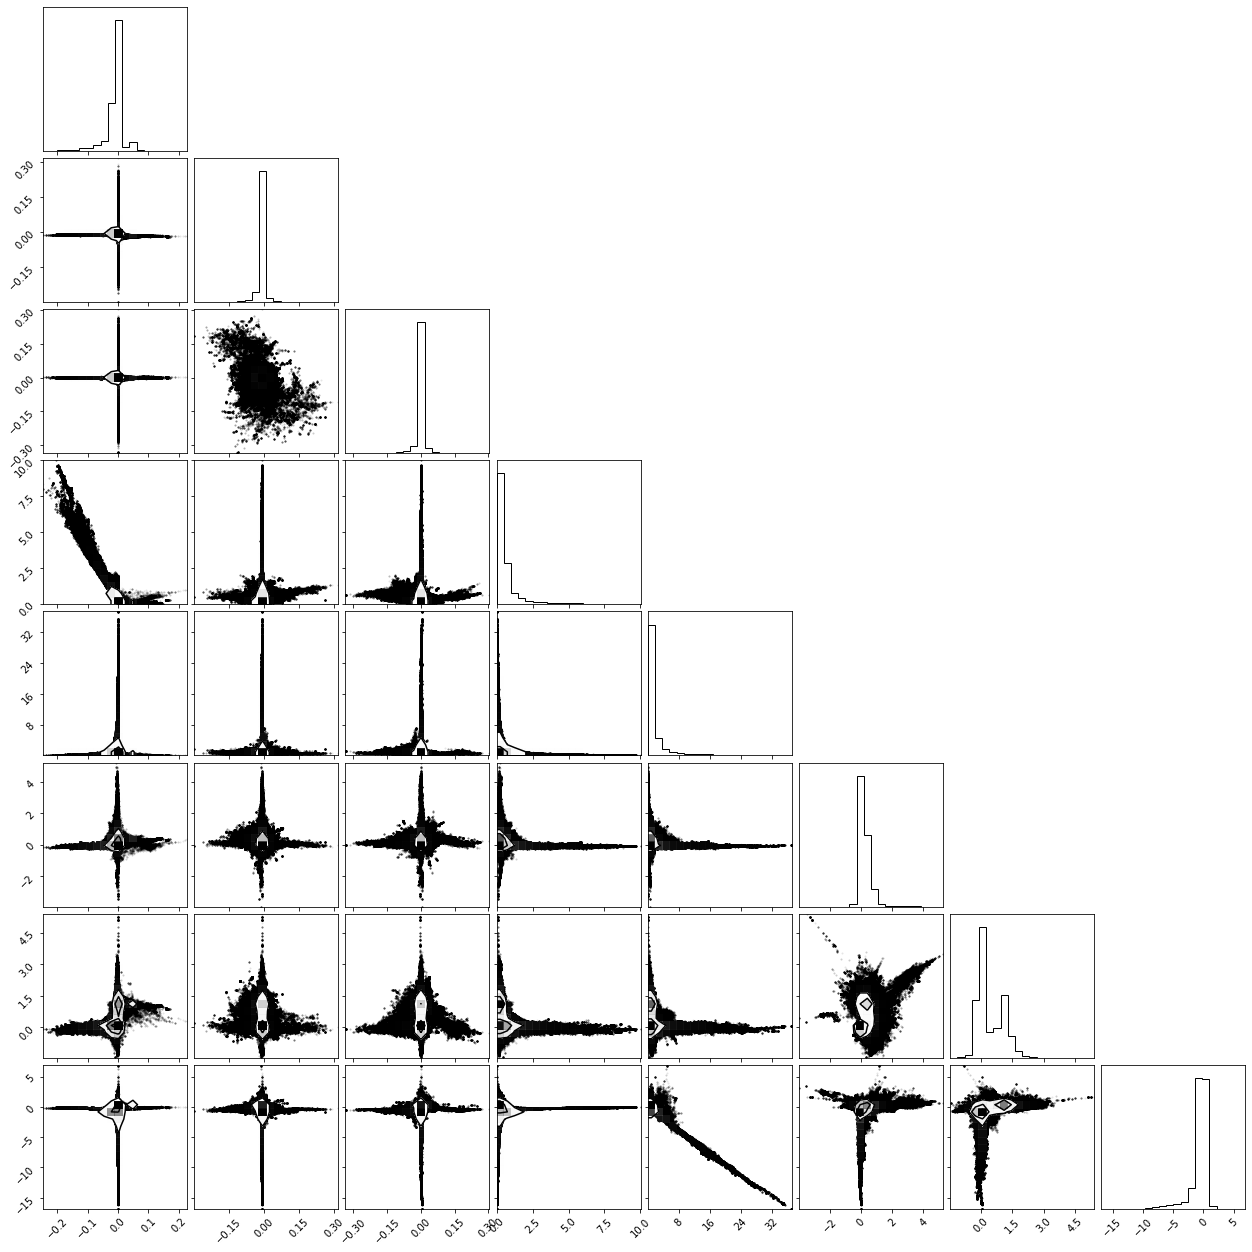

In [55]:
_ = corner.corner(sampler.flatchain)

In [56]:
ll(np.mean(sampler.flatchain[:-10000],axis=0))

-1255.0168412569105

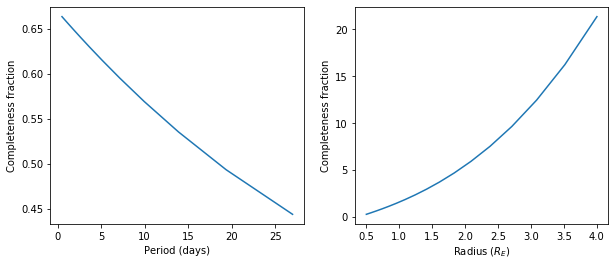

In [57]:
params = np.mean(sampler.flatchain[:-10000], axis=0)
plot_marginalized_comps(params)

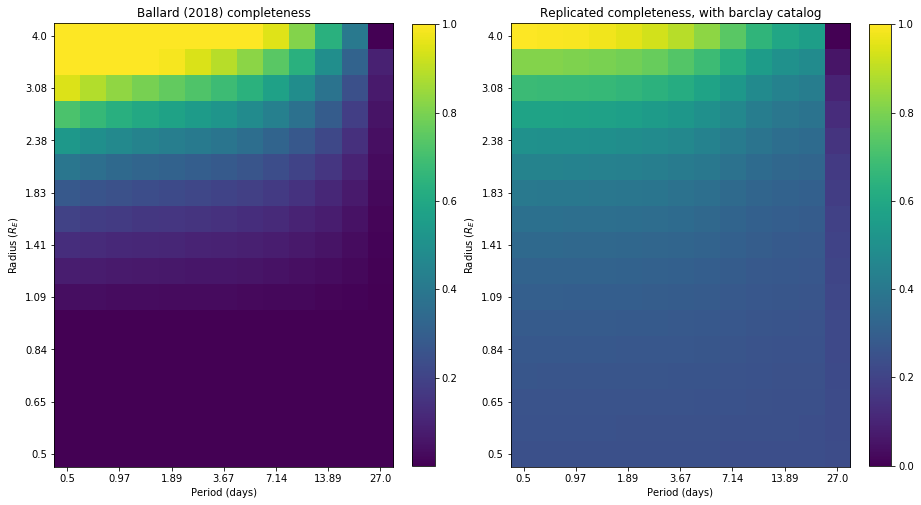

In [58]:
repcomp = np.outer(comp_poly(bins_p, *params[:4]), comp_poly(bins_r, *params[4:])).T
repcomp -= np.min(repcomp)
repcomp /= np.max(repcomp)
plot_overall_comps(repcomp, name)